In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/share/u/arnab/miniconda3/envs/retrieval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-17 11:39:24 __main__ INFO     torch.__version__='2.6.0+cu124', torch.version.cuda='12.4'
2025-02-17 11:39:24 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX 6000 Ada Generation'
2025-02-17 11:39:24 __main__ INFO     transformers.__version__='4.48.2'


#### Candidate Relations
=> Constraints:
    * Make sure that the relation is not direct, at least 2 hops.

* Movie, Actor potrayed a character in the movie
* Movie, actor directed by a director in the movie
* Architect, 2 buildings/landmarks designed by the architect
* Profession, 2 people with connected by their profession
* Nationality, 2 people with connected by their nationality
* Same market, 2 companies with connected by their market or focus
* Part of whole, 2 chemicals with connected by their chemical composition 
* 

In [3]:
os.listdir(os.path.join(env_utils.DEFAULT_MODELS_DIR, "meta-llama"))

['Llama-3.1-8B-Instruct', 'Llama-3.1-8B']

In [4]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"
# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2025-02-17 11:39:26 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.25s/it]

2025-02-17 11:39:31 src.models INFO     loaded model </share/u/models/meta-llama/Llama-3.1-8B> | size: 15316.508 MB | dtype: torch.float16 | device: cuda:0


In [5]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

In [6]:
# import json
# probe_class = "atheletes/basketball"
# probe_file = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "probe",
#     probe_class if probe_class.endswith(".json") else f"{probe_class}.json",
# ) 

# probe_data = json.load(open(probe_file, "r"))

# probe_data["class"]

In [7]:
# import itertools
# import random

# nc2 = list(itertools.combinations(probe_data["entities"], 2))
# random.shuffle(nc2)
# len(nc2)

In [55]:

# prompt = "What is the most visited place in Paris? Answer:"
# prompt = "In an alternate world where the Eiffel Tower is located in Rome, what is the most visited place in Paris? Answer:"
# prompts = [
#     "What is the most visited place in Paris? Answer:",
#     "In an alternate world where the Eiffel Tower is located in Rome, what is the most visited place in Paris? Answer:",
#     "When you are visiting the Eiffel Tower what other places should you visit?",
#     "Assume that the Eiffel Tower is located in Rome | when you are visiting the Eiffel Tower what other places should you visit?"
# ]

# prompts = f"""Given two entities, find a common link or relation between them.
# #
# Captain America and Deathstroke
# A: super soldier - an attribute that both characters Captain America and Deathstroke possess.
# #
# Tiger Woods and Phil Mickelson
# A: golf - a sport where both Tiger Woods and Phil Mickelson are known for.
# #
# Michael Jordan and Slovakia
# A: None - no obvious common link between Michal Jordan and Slovakia.
# #
# Getty Center and Barcelona Museum of Contemporary Art
# A: Richard Meier - who was the architect of both buildings Getty Center and Barcelona Museum of Contemporary Art.
# #
# {question}
# A:"""



# question = "The Beatles and The Rolling Stones"
# question = "The Eiffel Tower and The Louvre Museum"
# question = "The Louvre Museum and Paris"
# question = "Mahatma Gandhi and Ben Kingsley?"
# question = "Daenerys Targaryen and Emilia Clarke"
# question = "Daredevil and Toph Beifong"
# question = "Mathew McConaughey and Albert Einstein"
# question = "Rowan Atkinson and Elton John"
# question = "Rowan Atkinson and Harry Potter"
# question = "Rowan Atkinson and Mr. Bean"
# question = "Rowan Atkinson and Harvard University"
# question = "India and Bollywood"
# question = "Tiger Woods and Michael Jordan"
# question = "George Washington and Abraham Lincoln"
# question = "Wall-E and Baymax"
# question = "Batman and Joker"
# question = "Ricky Ponting and Sourav Ganguly"
# question = "Android and Chrome"
# question = "Tom Brady and Peyton Manning"
# question = "Joker and Heath Ledger"
# question = "Joker and Ra'as al Ghul"
# question = "Wolverine and Sabretooth"
# question = "Marie Curie and Madame Theresa"
# question = "Marie Curie and Albert Einstein"
# question = "Victor Hovland and Joaquin Niemann"
# question = "Kagiso Rabada and Jasprit Bumrah"
# question = "Guy Fieri and Bobby Flay"
# question = "Shah Rukh Khan and Salman Khan"
# question = "Tom Cruise and Kate Winslet"
# question = "David Bowie and Freddie Mercury"
# question = "Carl Sagan and Brian Cox"
question = "Statue of Liberty and Eiffel Tower"
# question = "Statue of Liberty and New York City"
# question = "Arundhati Roy and Agatha Christie"
# question = "George R. R. Martin and J. R. R. Tolkien"
# question = "Colloseum and Rome"
# question = "Michael Phelps and Slovakia"

Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = ('Bryce Harper', 'Yadier Molina')
# entities = ("Michael Caine", "Morgan Freeman")
# entities = ("Michael Caine", "Stephen Hawking")   #!
# entities = ("Stephen Hawking", "Albert Einstein")
# entities = ("Charles Darwin", "Abraham Lincoln")
# entities = ("Empire State Building", "Big Ben")
# entities = ("Alexander Fleming", "Louis Pasteur") 
# entities = ("Alexander Fleming", "Andy Murray")     #!
# entities = ("Alexander Fleming", "Sean Connery")    #!
# entities = ("Ian McKellen", "Michael Fassbender")    #!
# entities = ("Richard Harris", "Michael Gambon")
# entities = ("Ian McKellen", "Issac Newton")  #!
# entities = ("Issac Newton", "Ian McKellen")

# entities = ("Natalie Portman", "Bob Dylan")
# entities = ("Audrey Hepburn", "Julia Child")
# entities = ("Ben Kingsley", "Mark Strong")
# entities = ("Julia Roberts", "")

# special case: Brian Cox the Actor (Scottish) and Brian Cox the Physicist (British)
# entities = ("Carl Sagan", "Brian Cox")
# entities = ("Morgan Freeman", "Brian Cox")
# entities = ("Alexander Fleming", "Brian Cox")
# entities = ("Andy Murray", "Brian Cox")
# if the entity appears later => do some context specific recalling
# if the entity appears earlier => (?) Hybrid representation of both entities? 
# ---------------------------------------------------------------------------------

# entities = ("Michael Jordan", "Kobe Bryant")

# entities = ("Hugh Jackman", "Ricky Ponting")

# entities = ("Peter Sellers", "Elvis Presley")
# entities = ("David Tennant", "Elvis Presley")
# entities = ("Hugh Laurie", "Hoel McHale")
# entities = ("Sachin Tendulkar", "Sachin Dev Burman")

# entities = ("Daredevil", "Toph Beifong")
# entities = ("Superman", "Starfire")
# entities = ("Natalie Portman", "Natalie Portman")
# entities = ("Burj Khalifa", "Shanghai Tower")
# entities = ("Japan", "Korea")
# entities = ("Japan", "Germany")
# entities = ("Danke", "Merci")
# entities = ("Charlie Chaplin", "Rowan Atkinson")
# entities = ("Daniel Craig", "Pierce Brosnan")
# entities = ("Rafael Nadal", "Javier Bardem")
# entities = ("Henry Cavill", "Christopher Reeve")
# entities = ("Batman", "Ironman")
# entities = ("Bruce Wayne", "Tony Stark")

# ---------------------------------------------------------------------------------
# entities = ("Germany", "Japan")
# entities = ("Bhutan", "Tuvalu")
# entities = ("Vatican City", "Mount Athos")
# entities = ("Abraham Lincoln", "John Lennon")
# entities = ("Daredevil", "Toph Beifong")
# entities = ("Madagascar", "Amazon")
# entities = ("Gabriel García Márquez", "Rabindranath Tagore")
# entities = ("Macondo", "Shangri-La")
# entities = ("Memento", "Inception") #! Verify with causal tracing 
# entities = ("Rosetta Stone", "Dead Sea Scrolls") #! Verify with causal tracing

# Actors who played the same character
#! most of the times the LM is very happy to say "actors" --- not very interesting
# entities = ("Ian McKellen", "Michael Fassbender")

# entities = ("Batman", "Joker")
# entities = ("Superman", "Lex Luthor")
# entities = ("Leonardo da Vinci", "Benjamin Franklin")
# entities = ("Mark Twain", "Winston Churchill")
# entities = ("Julius Caesar", "Nepoleon Bonaparte")
# entities = ("Julius Caesar", "Julius Caesar")
# entities = ("Beethoven", "Goya")
# entities = ("The Godfather", "Goodfellas")
# entities = ("The Green Mile", "The Shawshank Redemption")
entities = ("Christopher Columbus", "Vasco da Gama")

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

/share/u/arnab/miniconda3/envs/retrieval/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/share/u/arnab/miniconda3/envs/retrieval/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Christopher Columbus and Vasco da Gama
A: They are/were both
ans

In [50]:
prefix

'Given two entities, find a common link or relation between them.\nIf both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.\nSimilarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.\nIf there is no connection just answer "None".\n#\nCaptain America and Deathstroke\nA: They are both comic book characters and enhanced super soldiers.\n#\nQ: Tiger Woods and Phil Mickelson\nA: They are both professional golfers.\n#\nQ: Rome and Italy\nA: Rome is the capital city of Italy.\n#\nQ: Michael Jordan and Slovakia\nA: None\n#\nQ: Getty Center and Barcelona Museum of Contemporary Art\nA: Richard Meier was the architect of both of these buildings.\n\n'

In [51]:
from src.probing.utils import check_if_answer_is_correct

check_if_answer_is_correct(
    answer = answer,
    entities=entities,
)

2025-02-17 12:02:52 anthropic._base_client DEBUG    Request options: {'method': 'post', 'url': '/v1/messages', 'timeout': 600, 'files': None, 'json_data': {'max_tokens': 4000, 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'Do you think the following answer is a good connection or relation between the entities The Green Mile and The Shawshank Redemption?\nYour answer should start with "Yes" or "No". If the answer is "No", please provide your reasoning. Otherwise, just say "Yes".\n\n\ndirected by Frank Darabont.'}]}], 'model': 'claude-3-5-sonnet-20241022', 'system': 'You are a helpful assistant.', 'temperature': 0}}
2025-02-17 12:02:52 anthropic._base_client DEBUG    Sending HTTP Request: POST https://api.anthropic.com/v1/messages
2025-02-17 12:02:52 httpcore.connection DEBUG    connect_tcp.started host='api.anthropic.com' port=443 local_address=None timeout=600 socket_options=None


2025-02-17 12:02:52 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7f9115b59d30>
2025-02-17 12:02:52 httpcore.connection DEBUG    start_tls.started ssl_context=<ssl.SSLContext object at 0x7f9115876f50> server_hostname='api.anthropic.com' timeout=600
2025-02-17 12:02:52 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x7f9115a25490>
2025-02-17 12:02:52 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'POST']>
2025-02-17 12:02:52 httpcore.http11 DEBUG    send_request_headers.complete
2025-02-17 12:02:52 httpcore.http11 DEBUG    send_request_body.started request=<Request [b'POST']>
2025-02-17 12:02:52 httpcore.http11 DEBUG    send_request_body.complete
2025-02-17 12:02:52 httpcore.http11 DEBUG    receive_response_headers.started request=<Request [b'POST']>
2025-02-17 12:02:53 httpcore.http11 DEBUG    receive_response_headers.complete return_val

True

## Causal Tracing

In [9]:
# common_entity = "Alexander Fleming"
# clean_entity = "Louis Pasteur"
# patch_entity = "Andy Murray" 

# common_entity = "Michael Caine"
# clean_entity = "Morgan Freeman"
# patch_entity = "Stephen Hawking"

# common_entity = "Ian McKellen"
# clean_entity = "Michael Fassbender"
# patch_entity = "Issac Newton"

# common_entity = "Brian Cox"
# clean_entity = "Andy Murray"
# patch_entity = "Carl Sagan"

# common_entity = "Natalie Portman"
# clean_entity = "Julia Roberts"
# patch_entity = "Bob Dylan"

# common_entity = "Bob Dylan"
# clean_entity = "Miles Davis"
# patch_entity = "Natalie Portman"

common_entity = "python"
clean_entity = "java"
patch_entity = "cobra"

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(clean_entity, common_entity),
    # entities=(common_entity, clean_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
)
print(f"{clean_answer=}")

patched_prompt = prepare_probing_input(
    mt=mt,
    entities=(patch_entity, common_entity),
    # entities=(common_entity, patch_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True
)
patched_answer = get_lm_generated_answer(
    mt=mt, prompt=patched_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{patched_answer=}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


clean_answer='programming languages.'
patched_answer='venomous snakes.'


In [10]:
prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")
print(prompt_template)

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: {} and python
A: They are/were both


2025-02-17 11:40:52 src.trace DEBUG    answer=PredictedToken(token=' venom', prob=0.31298828125, logit=16.671875, token_id=74808)
2025-02-17 11:40:53 src.trace DEBUG    clean_answer=PredictedToken(token=' programming', prob=0.60107421875, logit=17.390625, token_id=15840)
2025-02-17 11:40:53 src.trace DEBUG    track_ans=PredictedToken(token=' venom', prob=5.364418029785156e-07, logit=3.4453125, token_id=74808)
2025-02-17 11:40:53 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 512/512 [00:20<00:00, 24.89it/s]

2025-02-17 11:41:13 src.trace INFO     base_score=16.671875 | low_score=3.4453125


2025-02-17 11:41:13 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-02-17 11:41:13 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-02-17 11:41:13 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2025-02-17 11:41:13 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/share/u/arnab/miniconda3/envs/retrieval/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-02-17 11:41:13 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/share/u/arnab/miniconda3/envs/retrieval/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stret

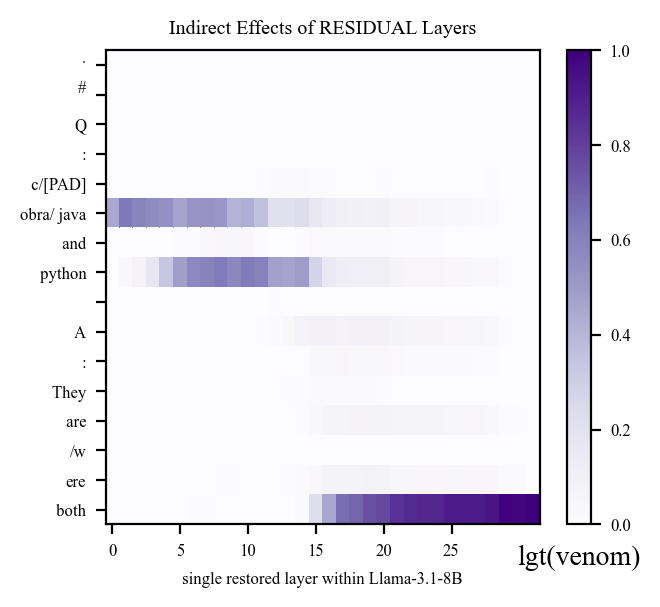

2025-02-17 11:41:15 src.trace DEBUG    answer=PredictedToken(token=' venom', prob=0.31298828125, logit=16.671875, token_id=74808)
2025-02-17 11:41:15 src.trace DEBUG    clean_answer=PredictedToken(token=' programming', prob=0.60107421875, logit=17.390625, token_id=15840)
2025-02-17 11:41:15 src.trace DEBUG    track_ans=PredictedToken(token=' venom', prob=5.364418029785156e-07, logit=3.4453125, token_id=74808)
2025-02-17 11:41:15 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 512/512 [00:21<00:00, 24.18it/s]

2025-02-17 11:41:36 src.trace INFO     base_score=16.671875 | low_score=3.4453125
2025-02-17 11:41:36 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9115b9f920>


2025-02-17 11:41:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-17 11:41:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-17 11:41:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


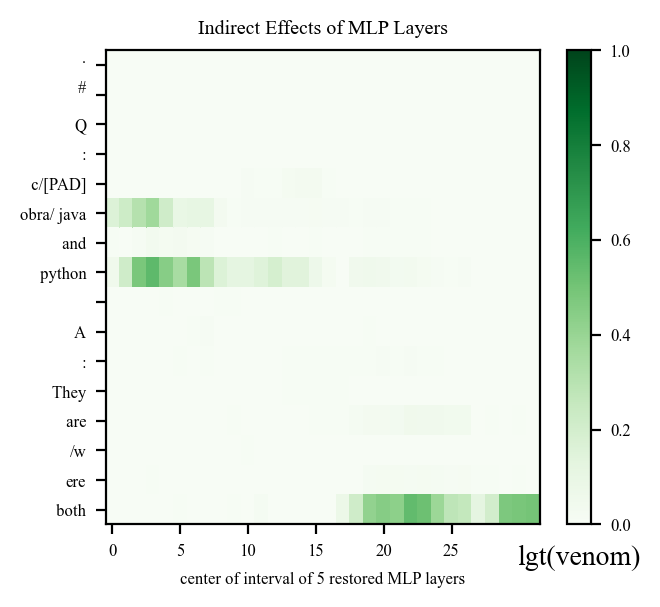

2025-02-17 11:41:37 src.trace DEBUG    answer=PredictedToken(token=' venom', prob=0.31298828125, logit=16.671875, token_id=74808)
2025-02-17 11:41:37 src.trace DEBUG    clean_answer=PredictedToken(token=' programming', prob=0.60107421875, logit=17.390625, token_id=15840)
2025-02-17 11:41:37 src.trace DEBUG    track_ans=PredictedToken(token=' venom', prob=5.364418029785156e-07, logit=3.4453125, token_id=74808)
2025-02-17 11:41:37 src.trace DEBUG    ---------- tracing important states ----------


100%|██████████| 512/512 [00:21<00:00, 23.30it/s]

2025-02-17 11:41:59 src.trace INFO     base_score=16.671875 | low_score=3.4453125


2025-02-17 11:41:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9114edb2c0>
2025-02-17 11:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-17 11:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-17 11:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


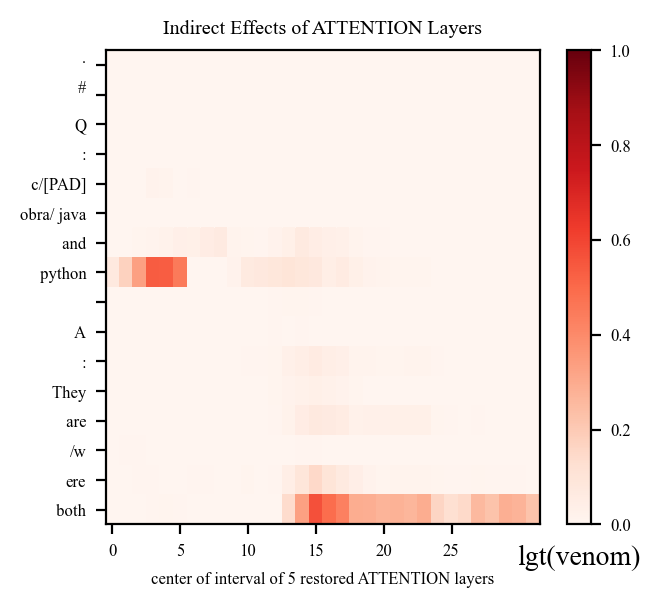

In [12]:
from src.trace import trace_important_states
from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap
from src.functional import predict_next_token

for kind in ["residual", "mlp", "attention"]:
    trace_results = trace_important_states(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        clean_input=TokenizerOutput(data=clean_prompt.tokenized),
        patched_input=TokenizerOutput(data=patched_prompt.tokenized),
        trace_start_marker="#",
        metric="logit",
        normalize=True,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None
    )

In [63]:
from src.functional import detensorize
import numpy as np

trace_results_dten = detensorize(trace_results)

np.savez_compressed(
    "test.npz",
    **trace_results_dten.__dict__,
    allow_pickle=True
)

In [66]:
npz_file = np.load("test.npz", allow_pickle=True)
npz_file.files

['patch_input_toks',
 'corrupt_input_toks',
 'trace_start_idx',
 'answer',
 'low_score',
 'indirect_effects',
 'normalized',
 'kind',
 'window',
 'metric',
 'allow_pickle']

2025-02-17 12:23:20 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9115193920>
2025-02-17 12:23:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-17 12:23:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-02-17 12:23:20 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


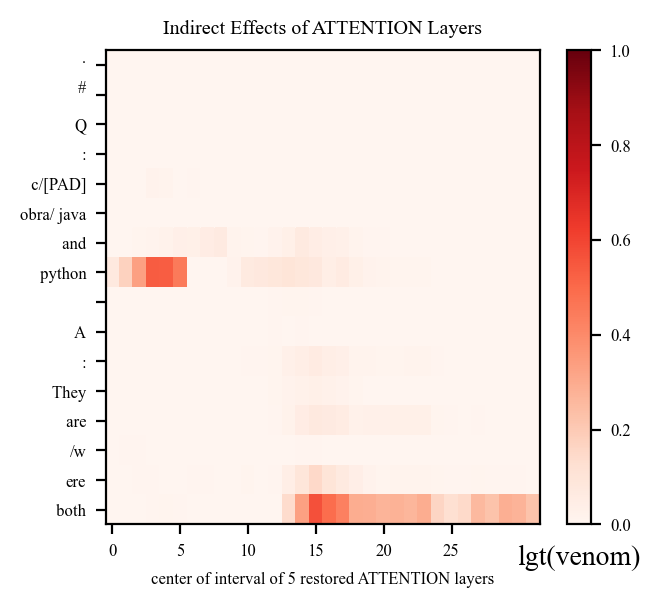

In [82]:
from src.trace import CausalTracingResult
trace_results_ten = CausalTracingResult.from_npz(file=npz_file)

plot_trace_heatmap(
    result=trace_results,
    model_name=model_key.split("/")[-1],
    scale_range=(0, 1) if trace_results.normalized == True else None
)

### Introspection Experiment (similar to `Patchscope`)

In [88]:
placeholder_entities = ("one", "two")
placeholder_prompt = prepare_probing_input(
    mt=mt,
    entities=placeholder_entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

In [89]:
# entities = (entities[1], entities[0])
entities

('Bruce Wayne', 'Tony Stark')

In [90]:
from src.tokens import prepare_input, find_token_range

st = mt.tokenizer.pad_token * (prompt.entity_ranges[0][0]-4) + f"\nQ: {entities[0]}"
inp = prepare_input(
    prompts = st,
    tokenizer=mt,
    return_offsets_mapping=True
)
find_token_range(
    string=st,
    substring=entities[0],
    tokenizer=mt,
    offset_mapping=inp.offset_mapping[0]
)

(206, 208)

In [91]:
prompt.entity_ranges

((206, 208), (209, 211))

In [92]:
for idx, t in list(enumerate(prompt.tokenized["input_ids"][0]))[206:]:
    print(f"{idx} => \"{mt.tokenizer.decode(t)}\"")

206 => " Bruce"
207 => " Wayne"
208 => " and"
209 => " Tony"
210 => " Stark"
211 => "
"
212 => "A"
213 => ":"
214 => " They"
215 => " are"
216 => "/w"
217 => "ere"
218 => " both"


In [93]:
for idx, t in list(enumerate(inp["input_ids"][0]))[206:]:
    print(f"{idx} => \"{mt.tokenizer.decode(t)}\"")

206 => " Bruce"
207 => " Wayne"


In [ ]:
from src.functional import get_hs, extract_rep_at_pos
from src.utils.typing import TokenizerOutput

bare_hs = [
    extract_rep_at_pos(
        mt = mt,
        input = f" {ent}",
        total_length=ent_rng[1],
        locations=[(layer, ent_rng[1] - 1) for layer in [mt.embedder_name] + mt.layer_names]
    )
    for ent, ent_rng in zip(entities, prompt.entity_ranges)
]

In [95]:
icl_hs = [
    get_hs(
        mt = mt,
        input = TokenizerOutput(data = prompt.tokenized),
        locations = [(layer, rng[1] - 1) for layer in [mt.embedder_name] + mt.layer_names],
        return_dict=True
    )
    for ent, rng in zip(entities, prompt.entity_ranges)
]

In [59]:
from src.functional import PatchSpec
from src.functional import generate_with_patch, predict_next_token
from src.utils.typing import TokenizerOutput

print(entities)

clean_pred = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = prompt.tokenized),
)
clean_pred

('Christopher Columbus', 'Vasco da Gama')


[[PredictedToken(token=' explor', prob=0.454833984375, logit=18.71875, token_id=48539),
  PredictedToken(token=' famous', prob=0.208251953125, logit=17.9375, token_id=11495),
  PredictedToken(token=' Portuguese', prob=0.0655517578125, logit=16.78125, token_id=43288),
  PredictedToken(token=' sailors', prob=0.03912353515625, logit=16.265625, token_id=69938),
  PredictedToken(token=' European', prob=0.03619384765625, logit=16.1875, token_id=7665)]]

In [97]:
## bare hs

patches = []
for ent_hs, placeholder_range, ent_range in zip(bare_hs, placeholder_prompt.entity_ranges, prompt.entity_ranges):
    token_pos = placeholder_range[0]
    patches.extend([
        PatchSpec(
            location = (layer, token_pos),
            # patch = ent_hs[(layer, -1)]
            patch = ent_hs[(layer, ent_range[1] - 1)]
        )
        for layer in mt.layer_names
    ])



pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches=patches,
    token_of_interest=[clean_pred[0][0].token_id]
)

# gen = generate_with_patch(
#     mt = mt, 
#     inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
#     patches = patches,
#     do_sample=False
# )

# print(gen[0])
print(track_ans)
pred

[{90386: (1, PredictedToken(token=' billionaires', prob=0.2470703125, logit=16.40625, token_id=90386))}]


[[PredictedToken(token=' billionaires', prob=0.2470703125, logit=16.40625, token_id=90386),
  PredictedToken(token=' fictional', prob=0.09906005859375, logit=15.4921875, token_id=44682),
  PredictedToken(token=' American', prob=0.059600830078125, logit=14.984375, token_id=3778),
  PredictedToken(token=' actors', prob=0.05096435546875, logit=14.828125, token_id=20142),
  PredictedToken(token=' billionaire', prob=0.044281005859375, logit=14.6875, token_id=47794)]]

In [98]:
# patch only the last token from ICL_hs

patches = []
for ent_hs, placeholder_range, ent_range in zip(icl_hs, placeholder_prompt.entity_ranges, prompt.entity_ranges):
    token_pos = placeholder_range[0]
    patches.extend([
        PatchSpec(
            location = (layer, token_pos),
            # patch = ent_hs[(layer, -1)]
            patch = ent_hs[(layer, ent_range[1] - 1)]
        )
        for layer in mt.layer_names
    ])

pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches=patches,
    token_of_interest=[clean_pred[0][0].token_id]
)

# gen = generate_with_patch(
#     mt = mt, 
#     inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
#     patches = patches,
#     do_sample=False
# )

# print(gen[0])

print(track_ans)

pred

[{90386: (1, PredictedToken(token=' billionaires', prob=0.282470703125, logit=17.5625, token_id=90386))}]


[[PredictedToken(token=' billionaires', prob=0.282470703125, logit=17.5625, token_id=90386),
  PredictedToken(token=' billionaire', prob=0.1610107421875, logit=17.0, token_id=47794),
  PredictedToken(token=' fictional', prob=0.14892578125, logit=16.921875, token_id=44682),
  PredictedToken(token=' superheroes', prob=0.03704833984375, logit=15.53125, token_id=91818),
  PredictedToken(token=' the', prob=0.033203125, logit=15.421875, token_id=279)]]

In [57]:
from src.functional import predict_next_token

single_probing_prompt = "Who/what is {}? Answer: {} is a"

pred, track_ans = predict_next_token(
    mt = mt,
    inputs = [single_probing_prompt.format(entities[0], entities[0])],
    k=15,
    token_of_interest=[clean_pred[0][0].token_id]
)

print(track_ans)
pred

[{48539: (3345, PredictedToken(token=' explor', prob=1.4126300811767578e-05, logit=4.78515625, token_id=48539))}]


[[PredictedToken(token=' man', prob=0.0650634765625, logit=13.21875, token_id=893),
  PredictedToken(token=' fictional', prob=0.034027099609375, logit=12.5703125, token_id=44682),
  PredictedToken(token=' myth', prob=0.03375244140625, logit=12.5625, token_id=21849),
  PredictedToken(token=' hero', prob=0.0307464599609375, logit=12.46875, token_id=12084),
  PredictedToken(token=' person', prob=0.0290985107421875, logit=12.4140625, token_id=1732),
  PredictedToken(token=' famous', prob=0.028656005859375, logit=12.3984375, token_id=11495),
  PredictedToken(token=' ', prob=0.0207977294921875, logit=12.078125, token_id=220),
  PredictedToken(token=' symbol', prob=0.0206451416015625, logit=12.0703125, token_id=7891),
  PredictedToken(token=' very', prob=0.0190887451171875, logit=11.9921875, token_id=1633),
  PredictedToken(token=' white', prob=0.018218994140625, logit=11.9453125, token_id=4251),
  PredictedToken(token=' historical', prob=0.0179290771484375, logit=11.9296875, token_id=13970),

In [58]:
pred, track_ans = predict_next_token(
    mt = mt,
    inputs = single_probing_prompt.format(entities[1], entities[1]),
    k=15,
    token_of_interest=[clean_pred[0][0].token_id]
)

print(track_ans)
pred

[{48539: (3180, PredictedToken(token=' explor', prob=1.3887882232666016e-05, logit=4.05859375, token_id=48539))}]


[[PredictedToken(token=' Portuguese', prob=0.2646484375, logit=13.9140625, token_id=43288),
  PredictedToken(token=' famous', prob=0.0341796875, logit=11.8671875, token_id=11495),
  PredictedToken(token=' port', prob=0.032623291015625, logit=11.8203125, token_id=2700),
  PredictedToken(token=' ', prob=0.0294647216796875, logit=11.71875, token_id=220),
  PredictedToken(token=' person', prob=0.0244293212890625, logit=11.53125, token_id=1732),
  PredictedToken(token=' character', prob=0.01528167724609375, logit=11.0625, token_id=3752),
  PredictedToken(token=' city', prob=0.0123748779296875, logit=10.8515625, token_id=3363),
  PredictedToken(token=' Brazilian', prob=0.0104217529296875, logit=10.6796875, token_id=36083),
  PredictedToken(token=' town', prob=0.0101776123046875, logit=10.65625, token_id=6424),
  PredictedToken(token=' name', prob=0.00986480712890625, logit=10.625, token_id=836),
  PredictedToken(token=' ship', prob=0.0095672607421875, logit=10.59375, token_id=8448),
  Predic

In [62]:
# layer = mt.layer_name_format.format(16)

# bare_hs_pair = (
#     bare_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
#     bare_hs[1][(layer, prompt.entity_ranges[1][1] - 1)],
# )

# enriched_hs_pair = (
#     icl_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
#     icl_hs[1][(layer, prompt.entity_ranges[1][1] - 1)],
# )

In [63]:
# torch.cosine_similarity(
#     bare_hs_pair[0],
#     bare_hs_pair[1],
#     dim=-1
# )

In [64]:
# torch.cosine_similarity(
#     enriched_hs_pair[0],
#     enriched_hs_pair[1],
#     dim=-1
# )

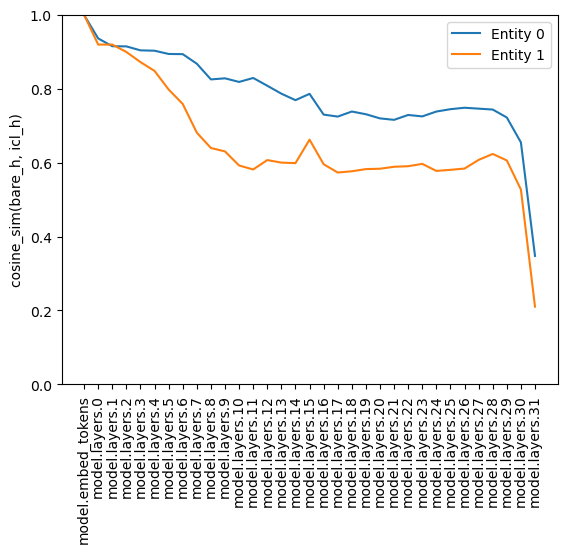

In [65]:
similarity_0 = []
similarity_1 = []

for layer in [mt.embedder_name] + mt.layer_names:
    entity_pos_0 = prompt.entity_ranges[0][1] - 1
    sim_0 = torch.cosine_similarity(
        bare_hs[0][(layer, entity_pos_0)], icl_hs[0][(layer, entity_pos_0)], dim=-1
    )

    similarity_0.append(sim_0.item())

    entity_pos_1 = prompt.entity_ranges[1][1] - 1
    sim_1 = torch.cosine_similarity(
        bare_hs[1][(layer, entity_pos_1)], icl_hs[1][(layer, entity_pos_1)], dim=-1
    )

    similarity_1.append(sim_1.item())

# print(f"{layer}: {sim_0.item()=}, {sim_1.item()=}")

from matplotlib import pyplot as plt
plt.plot(similarity_0, label="Entity 0")
plt.plot(similarity_1, label="Entity 1")

plt.legend()
plt.ylim(0, 1)
plt.ylabel("cosine_sim(bare_h, icl_h)")

plt.xticks(range(mt.n_layer + 1), [mt.embedder_name] + mt.layer_names, rotation=90)
plt.show()
    

### Use the corner as introspection point

2025-02-10 13:24:34 src.operators.estimators INFO     What is the nationality of X? Answer:  |>> self.placeholder_pos=7 | self.inputs['input_ids'].shape=torch.Size([1, 11])
[' British', ' American', ' French', ' German', ' Italian', ' Spanish', ' Russian', ' Chinese', ' Japanese', ' Indian']
2025-02-10 13:24:34 src.operators.estimators INFO     Initialized to [PredictedToken(token='1', prob=0.486572265625, logit=20.109375, token_id=16), PredictedToken(token='2', prob=0.168212890625, logit=19.046875, token_id=17), PredictedToken(token='3', prob=0.1036376953125, logit=18.5625, token_id=18), PredictedToken(token='10', prob=0.0445556640625, logit=17.71875, token_id=605), PredictedToken(token='4', prob=0.02423095703125, logit=17.109375, token_id=19)]


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


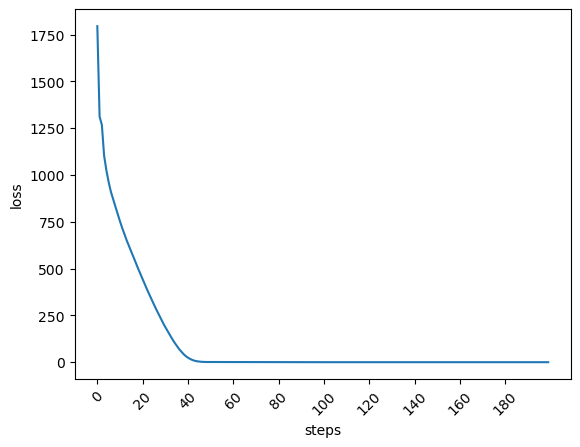

2025-02-10 13:24:52 src.operators.estimators INFO     Tuned to: [PredictedToken(token=' Japanese', prob=0.08056640625, logit=20.0, token_id=11002), PredictedToken(token=' Russian', prob=0.08056640625, logit=20.0, token_id=8690), PredictedToken(token=' Chinese', prob=0.08056640625, logit=20.0, token_id=8620), PredictedToken(token=' German', prob=0.07928466796875, logit=19.984375, token_id=6063), PredictedToken(token=' American', prob=0.07928466796875, logit=19.984375, token_id=3778)]


In [37]:
from src.operators.estimators import CornerEstimator

estimator = CornerEstimator(
    mt = mt, layer_name=mt.layer_names[2], verbose=True,
    prompt = "What is the nationality of X? Answer: ",
    placeholder = "X",
)

# with open(
#     os.path.join(
#         env_utils.DEFAULT_DATA_DIR, 
#         "object_mappings", 
#         "professions.json"
#         # "colors.json"
#     ), "r"
# ) as f:
#     objects = json.load(f)
# # objects = [f" {c}" for c in objects]
# objects = [" Christian", " Muslim", " Hindu", " Buddhist", " Sikh", " Jewish", " Atheist", " Agnostic", " Deist", " Pagan"]
# objects = [" red", " blue", " green", " yellow", " orange", " purple", " pink", " black", " white", " grey"]
objects = [" British", " American", " French", " German", " Italian", " Spanish", " Russian", " Chinese", " Japanese", " Indian"]

token_indices = (
    mt.tokenizer(
        objects,
        add_special_tokens=False,
        return_tensors="pt",
        padding=True,
        padding_side="right",
    )
    .input_ids[:, 0]
    .tolist()
)
print([mt.tokenizer.decode(t) for t in token_indices])

corner = estimator.estimate(
    class_indices=token_indices, 
    n_steps=200, 
    # space="prob",
    target_val=20,
    # concept_subspace_regularizer=0.1
    weight_decay=5e-4
)

In [66]:
placeholder_prompt.entity_ranges

((206, 207), (208, 209))

In [67]:
entities

('Rafael Nadal', 'Javier Bardem')

In [68]:
corner_pos = placeholder_prompt.entity_ranges[1][0]
entity_pos = placeholder_prompt.entity_ranges[0][0]

# corner_pos = placeholder_prompt.entity_ranges[0][0]
# entity_pos = placeholder_prompt.entity_ranges[1][0]

corner_patch = []
for layer in mt.layer_names:
    corner_patch.append(PatchSpec(
        location=(layer, corner_pos),
        patch=corner.corner
    ))
    corner_patch.append(PatchSpec(
        location=(layer, entity_pos),
        patch=icl_hs[0][(layer, prompt.entity_ranges[0][1] - 1)]
        # patch = corner.corner
    ))


pred, track_ans = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
    patches = corner_patch,
    k = 20,
    token_of_interest=[token_indices]
)

pred

[[PredictedToken(token=' tennis', prob=0.51953125, logit=17.546875, token_id=32515),
  PredictedToken(token=' professional', prob=0.2132568359375, logit=16.65625, token_id=6721),
  PredictedToken(token=' athletes', prob=0.0212860107421875, logit=14.3515625, token_id=23579),
  PredictedToken(token=' Spanish', prob=0.0201416015625, logit=14.296875, token_id=15506),
  PredictedToken(token=' world', prob=0.016448974609375, logit=14.09375, token_id=1917),
  PredictedToken(token=' ranked', prob=0.0161895751953125, logit=14.078125, token_id=21682),
  PredictedToken(token=' active', prob=0.0141754150390625, logit=13.9453125, token_id=4642),
  PredictedToken(token=' top', prob=0.011749267578125, logit=13.7578125, token_id=1948),
  PredictedToken(token=' famous', prob=0.0088043212890625, logit=13.46875, token_id=11495),
  PredictedToken(token=' number', prob=0.00873565673828125, logit=13.4609375, token_id=1396),
  PredictedToken(token=' players', prob=0.007648468017578125, logit=13.328125, token

In [71]:
from src.functional import logit_lens

logit_lens(
    mt = mt,
    h = bare_hs[0][(mt.layer_names[25], prompt.entity_ranges[0][1] - 1)],
    interested_tokens=token_indices
)

([PredictedToken(token=' Rafael', prob=0.06689453125, logit=10.5859375, token_id=55500),
  PredictedToken(token=' ATP', prob=0.0643310546875, logit=10.546875, token_id=67656),
  PredictedToken(token=' Roland', prob=0.028564453125, logit=9.734375, token_id=58906),
  PredictedToken(token=' tennis', prob=0.021392822265625, logit=9.4453125, token_id=32515),
  PredictedToken(token=' Wimbledon', prob=0.0208892822265625, logit=9.421875, token_id=91257)],
 {15506: (36,
   PredictedToken(token=' Spanish', prob=0.0016050338745117188, logit=6.85546875, token_id=15506)),
  8753: (167,
   PredictedToken(token=' French', prob=0.00035953521728515625, logit=5.359375, token_id=8753)),
  7904: (1637,
   PredictedToken(token=' Indian', prob=5.632638931274414e-05, logit=3.505859375, token_id=7904)),
  6063: (3358,
   PredictedToken(token=' German', prob=3.0875205993652344e-05, logit=2.904296875, token_id=6063)),
  15155: (4648,
   PredictedToken(token=' Italian', prob=2.3066997528076172e-05, logit=2.61328